In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import xgboost as xgb

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection  import SelectKBest, f_regression, mutual_info_regression

import pandas as pd
import numpy as np

import eli5
from tqdm import tqdm
import joblib
import matplotlib as plt

In [2]:
df = pd.read_excel("data_train.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 53 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   AT_KM                2748 non-null   float64       
 1   BE_KM                2748 non-null   float64       
 2   CZ_KM                2748 non-null   float64       
 3   DE_KM                2748 non-null   float64       
 4   DK_KM                2748 non-null   float64       
 5   EE_KM                2748 non-null   float64       
 6   ES_KM                2748 non-null   float64       
 7   FI_KM                2748 non-null   float64       
 8   HR_KM                2748 non-null   float64       
 9   FR_KM                2748 non-null   float64       
 10  HU_KM                2748 non-null   float64       
 11  IT_KM                2748 non-null   float64       
 12  LT_KM                2748 non-null   float64       
 13  LV_KM                2748 non-nul

In [4]:
# Value Complement

df['AT_KM'] = df['AT_KM'].fillna(0)
df['CZ_KM'] = df['CZ_KM'].fillna(0)
df['DE_KM'] = df['DE_KM'].fillna(0)
df['EE_KM'] = df['EE_KM'].fillna(0)
df['HU_KM'] = df['HU_KM'].fillna(0)
df['LT_KM'] = df['LT_KM'].fillna(0)
df['LV_KM'] = df['LV_KM'].fillna(0)
df['PL_KM'] = df['PL_KM'].fillna(0)
df['SE_KM'] = df['SE_KM'].fillna(0)
df['SK_KM'] = df['SK_KM'].fillna(0)

df['VEHICLE_TYPE'] = df['VEHICLE_TYPE'].fillna('other')
df['VEHICLE_TYPE'] = pd.factorize(df['VEHICLE_TYPE'])[0]

df['BODY_TYPE'] = df['BODY_TYPE'].fillna('other')
body = df.groupby('BODY_TYPE')
body.filter(lambda x: len(x) >= 2)
df.loc[body['BODY_TYPE'].transform(lambda x: len(x) < 2).astype(bool), 'BODY_TYPE'] = 'other'

df['LOAD_UNLOAD_METHOD'] = df['LOAD_UNLOAD_METHOD'].fillna('other')
df['LOAD_UNLOAD_METHOD'] = pd.factorize(df['LOAD_UNLOAD_METHOD'])[0]

df['EPALE'] = df['EPALE'].fillna(0)

df['GOODS_TYPE'] = df['GOODS_TYPE'].fillna('other')
df['GOODS_TYPE'] = pd.factorize(df['GOODS_TYPE'])[0]

df['TEMP_MIN'].fillna(int(df['TEMP_MIN'].mean()), inplace=True)
df['TEMP_MAX'].fillna(int(df['TEMP_MAX'].mean()), inplace=True)

df['REQUIREMENTS'] = df['REQUIREMENTS'].fillna('other')
df['REQUIREMENTS'] = pd.factorize(df['REQUIREMENTS'])[0]

df['OTHER_COSTS'] = df['OTHER_COSTS'].fillna(0)

df['QTY_LOADS'] = df['QTY_LOADS'].fillna(1)
df['QTY_DELIVERIES'] = df['QTY_DELIVERIES'].fillna(1)

#del df["M3"]
#del df["HEIGHT"]
#del df["WIDTH"]

df['PAYMENT TERM'].fillna(int(df['PAYMENT TERM'].mean()), inplace=True)

df['CARGO_VALUE_EURO'].fillna(int(df['CARGO_VALUE_EURO'].mean()), inplace=True)

df['CUSTOMS'] = df['CUSTOMS'].fillna(0) #0 - no customs, 1 customs export or import, 2 export and import customss

df["KM"] = df['AT_KM'] + df['BE_KM'] + df['CZ_KM'] + df['DE_KM'] + df['DK_KM'] + df['EE_KM'] + df['ES_KM'] + df['FI_KM'] + df['HR_KM']  + df['FR_KM'] + df['HU_KM'] + df['IT_KM'] + df['LT_KM'] + df['LV_KM'] + df['NL_KM'] + df['PL_KM'] + df['RO_KM'] + df['SE_KM'] + df['SI_KM'] + df['SK_KM']
df["NETTO_EURO"] = df['EURO'] + df['OTHER_COSTS']
df["NETTO_EURO_FOR_KM"] = df['NETTO_EURO'] / df['KM']

#df["id"] = df.index + 1

In [5]:
df["COUNTRY_LOAD_PLACE"] = df["COD_LP"].str[:2]
df['COUNTRY_LOAD_PLACE'] = pd.factorize(df['COUNTRY_LOAD_PLACE'])[0]
df["COUNTRY_DELIVERY_PLACE"] = df["COD_DP"].str[:2]
df['COUNTRY_DELIVERY_PLACE'] = pd.factorize(df['COUNTRY_DELIVERY_PLACE'])[0]
df["RELATION"] = df["COD_LP"].str[:2] + ' to ' + df["COD_DP"].str[:2]
df['RELATION'] = pd.factorize(df['RELATION'])[0]

In [6]:
df["START_LOAD_DATA"] = pd.to_datetime(df["START_LOAD_DATA"], dayfirst=False)
df["END_LOAD_DATA"] = pd.to_datetime(df["END_LOAD_DATA"], dayfirst=False)
df["START_DELIVERY_DATA"] = pd.to_datetime(df["START_DELIVERY_DATA"], dayfirst=False)
df["END_DELIVERY_DATA"] = pd.to_datetime(df["END_DELIVERY_DATA"], dayfirst=False)

In [7]:
#df = df.fillna(0)

In [8]:
def feature_engineering(df):
    
    df['START_LOAD_DATA_YEAR'] = df['START_LOAD_DATA'].dt.year
    df['START_LOAD_DATA_MONTH'] = df['START_LOAD_DATA'].dt.month
    df['START_LOAD_DATA_WEEK_OF_YEAR'] = df['START_LOAD_DATA'].dt.isocalendar().week
    df['START_LOAD_DATA_WEEKDAY'] = df['START_LOAD_DATA'].dt.weekday
    df['START_LOAD_DATA_DAY'] = df['START_LOAD_DATA'].dt.day
    df['START_LOAD_DATA_DAY_OF_YEAR'] = df['START_LOAD_DATA'].dt.dayofyear
    
    df['END_LOAD_DATA_YEAR'] = df['END_LOAD_DATA'].dt.year
    df['END_LOAD_DATA_MONTH'] = df['END_LOAD_DATA'].dt.month
    df['END_LOAD_DATA_WEEK_OF_YEAR'] = df['END_LOAD_DATA'].dt.isocalendar().week
    df['END_LOAD_DATA_WEEKDAY'] = df['END_LOAD_DATA'].dt.weekday
    df['END_LOAD_DATA_DAY'] = df['END_LOAD_DATA'].dt.day
    df['END_LOAD_DATA_DAY_OF_YEAR'] = df['END_LOAD_DATA'].dt.dayofyear
                                          
    df['START_DELIVERY_DATA_YEAR'] = df['START_DELIVERY_DATA'].dt.year
    df['START_DELIVERY_DATA_MONTH'] = df['START_DELIVERY_DATA'].dt.month
    df['START_DELIVERY_DATA_WEEK_OF_YEAR'] = df['START_DELIVERY_DATA'].dt.isocalendar().week
    df['START_DELIVERY_DATA_WEEKDAY'] = df['START_DELIVERY_DATA'].dt.weekday
    df['START_DELIVERY_DATA_DAY'] = df['START_DELIVERY_DATA'].dt.day
    df['START_DELIVERY_DATA_DAY_OF_YEAR'] = df['START_DELIVERY_DATA'].dt.dayofyear
                                                
    df['END_DELIVERY_DATA_YEAR'] = df['END_DELIVERY_DATA'].dt.year
    df['END_DELIVERY_DATA_MONTH'] = df['END_DELIVERY_DATA'].dt.month
    df['END_DELIVERY_DATA_WEEK_OF_YEAR'] = df['END_DELIVERY_DATA'].dt.isocalendar().week
    df['END_DELIVERY_DATA_WEEKDAY'] = df['END_DELIVERY_DATA'].dt.weekday
    df['END_DELIVERY_DATA_DAY'] = df['END_DELIVERY_DATA'].dt.day
    df['END_DELIVERY_DATA_DAY_OF_YEAR'] = df['END_DELIVERY_DATA'].dt.dayofyear
    
     # 1 feature,
        
    df_loadcountry = df[ ["COUNTRY_LOAD_PLACE", "NETTO_EURO_FOR_KM"] ].groupby(["COUNTRY_LOAD_PLACE"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_loadcountry.rename(columns = {'mean':'LOAD_COUNTRY_MEAN', 'median':'LOAD_COUNTRY_MEDIAN', 'std':'LOAD_COUNTRY_STD'}, inplace = True)
    df = pd.merge(df, df_loadcountry, on=["COUNTRY_LOAD_PLACE"], how="left")

    df_deliverycountry = df[ ["COUNTRY_DELIVERY_PLACE", "NETTO_EURO_FOR_KM"] ].groupby(["COUNTRY_DELIVERY_PLACE"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_deliverycountry.rename(columns = {'mean':'COUNTRY_DELIVERY_MEAN', 'median':'COUNTRY_DELIVERY_MEDIAN', 'std':'COUNTRY_DELIVERY_STD'}, inplace = True)
    df = pd.merge(df, df_deliverycountry, on=["COUNTRY_DELIVERY_PLACE"], how="left")

    df_relation = df[ ["RELATION", "NETTO_EURO_FOR_KM"] ].groupby(["RELATION"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_relation.rename(columns = {'mean':'RELATION_MEAN', 'median':'RELATION_MEDIAN', 'std':'RELATION_STD'}, inplace = True)
    df = pd.merge(df, df_relation, on=["RELATION"], how="left")

    df_vehicle = df[ ["VEHICLE_TYPE", "NETTO_EURO_FOR_KM"] ].groupby(["VEHICLE_TYPE"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_vehicle.rename(columns = {'mean':'VEHICLE_TYPE_MEAN', 'median':'VEHICLE_TYPE_MEDIAN', 'std':'VEHICLE_TYPE_STD'}, inplace = True)
    df = pd.merge(df, df_vehicle, on=["VEHICLE_TYPE"], how="left")

    df_body = df[ ["BODY_TYPE", "NETTO_EURO_FOR_KM"] ].groupby(["BODY_TYPE"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_body.rename(columns = {'mean':'BODY_TYPE_MEAN', 'median':'BODY_TYPE_MEDIAN', 'std':'BODY_TYPE_STD'}, inplace = True)
    df = pd.merge(df, df_body, on=["BODY_TYPE"], how="left")

    df_goods = df[ ["GOODS_TYPE", "NETTO_EURO_FOR_KM"] ].groupby(["GOODS_TYPE"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_goods.rename(columns = {'mean':'GOODS_TYPE_MEAN', 'median':'GOODS_TYPE_MEDIAN', 'std':'GOODS_TYPE_STD'}, inplace = True)
    df = pd.merge(df, df_goods, on=["GOODS_TYPE"], how="left")

    df_lum = df[ ["LOAD_UNLOAD_METHOD", "NETTO_EURO_FOR_KM"] ].groupby(["LOAD_UNLOAD_METHOD"]).agg(["mean","median","std"])["NETTO_EURO_FOR_KM"].reset_index()
    df_lum.rename(columns = {'mean':'LOAD_UNLOAD_METHOD_MEAN', 'median':'LOAD_UNLOAD_METHOD_MEDIAN', 'std':'LOAD_UNLOAD_METHOD_STD'}, inplace = True)
    df = pd.merge(df, df_lum, on=["LOAD_UNLOAD_METHOD"], how="left")
    
    df = df.fillna(0)
    
    return df

In [9]:
def get_feats(df, black_list=['EURO', 'NETTO_EURO','NETTO_EURO_FOR_KM', 'id']):
    return [x for x in df.select_dtypes(["number", "bool"]).columns if x not in black_list]

In [10]:
def get_X_y(df, fe=feature_engineering, verbose=False):
    df_new = fe(df.copy())
    feats = get_feats(df_new, black_list=['EURO'])
    if verbose:
        print("feats: ", feats)
    X = df_new[feats].values
    y = df["EURO"].values
    
    return X, y

In [11]:
#def train_and_valid(model, X, y, cv=5, scoring="neg_mean_absolute_error"):
def train_and_valid(model, X, y, cv=5, scoring="neg_mean_absolute_percentage_error"):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)

In [12]:
def e(model, cv=5, verbose=False):
    X, y = get_X_y(df, verbose=verbose)
    return train_and_valid(model, X, y, cv=cv)

In [13]:
e(DecisionTreeRegressor(random_state=0, max_depth=10), verbose=True)

feats:  ['AT_KM', 'BE_KM', 'CZ_KM', 'DE_KM', 'DK_KM', 'EE_KM', 'ES_KM', 'FI_KM', 'HR_KM', 'FR_KM', 'HU_KM', 'IT_KM', 'LT_KM', 'LV_KM', 'NL_KM', 'PL_KM', 'RO_KM', 'SE_KM', 'SI_KM', 'SK_KM', 'VEHICLE_TYPE', 'LOAD_UNLOAD_METHOD', 'EPALE', 'GOODS_TYPE', 'TEMP_MIN', 'TEMP_MAX', 'LDM', 'M3', 'HEIGHT', 'WIDTH', 'TONS', 'REQUIREMENTS', 'OTHER_COSTS', 'QTY_LOADS', 'QTY_DELIVERIES', 'PAYMENT TERM', 'CARGO_VALUE_EURO', 'CUSTOMS', 'KM', 'NETTO_EURO', 'NETTO_EURO_FOR_KM', 'COUNTRY_LOAD_PLACE', 'COUNTRY_DELIVERY_PLACE', 'RELATION', 'START_LOAD_DATA_YEAR', 'START_LOAD_DATA_MONTH', 'START_LOAD_DATA_WEEK_OF_YEAR', 'START_LOAD_DATA_WEEKDAY', 'START_LOAD_DATA_DAY', 'START_LOAD_DATA_DAY_OF_YEAR', 'END_LOAD_DATA_YEAR', 'END_LOAD_DATA_MONTH', 'END_LOAD_DATA_WEEK_OF_YEAR', 'END_LOAD_DATA_WEEKDAY', 'END_LOAD_DATA_DAY', 'END_LOAD_DATA_DAY_OF_YEAR', 'START_DELIVERY_DATA_YEAR', 'START_DELIVERY_DATA_MONTH', 'START_DELIVERY_DATA_WEEK_OF_YEAR', 'START_DELIVERY_DATA_WEEKDAY', 'START_DELIVERY_DATA_DAY', 'START_DELIVE

(-0.015831131780600242, 0.015737989536087463)

In [14]:
e(RandomForestRegressor(random_state=0, max_depth=10, n_estimators=100), verbose=True)

feats:  ['AT_KM', 'BE_KM', 'CZ_KM', 'DE_KM', 'DK_KM', 'EE_KM', 'ES_KM', 'FI_KM', 'HR_KM', 'FR_KM', 'HU_KM', 'IT_KM', 'LT_KM', 'LV_KM', 'NL_KM', 'PL_KM', 'RO_KM', 'SE_KM', 'SI_KM', 'SK_KM', 'VEHICLE_TYPE', 'LOAD_UNLOAD_METHOD', 'EPALE', 'GOODS_TYPE', 'TEMP_MIN', 'TEMP_MAX', 'LDM', 'M3', 'HEIGHT', 'WIDTH', 'TONS', 'REQUIREMENTS', 'OTHER_COSTS', 'QTY_LOADS', 'QTY_DELIVERIES', 'PAYMENT TERM', 'CARGO_VALUE_EURO', 'CUSTOMS', 'KM', 'NETTO_EURO', 'NETTO_EURO_FOR_KM', 'COUNTRY_LOAD_PLACE', 'COUNTRY_DELIVERY_PLACE', 'RELATION', 'START_LOAD_DATA_YEAR', 'START_LOAD_DATA_MONTH', 'START_LOAD_DATA_WEEK_OF_YEAR', 'START_LOAD_DATA_WEEKDAY', 'START_LOAD_DATA_DAY', 'START_LOAD_DATA_DAY_OF_YEAR', 'END_LOAD_DATA_YEAR', 'END_LOAD_DATA_MONTH', 'END_LOAD_DATA_WEEK_OF_YEAR', 'END_LOAD_DATA_WEEKDAY', 'END_LOAD_DATA_DAY', 'END_LOAD_DATA_DAY_OF_YEAR', 'START_DELIVERY_DATA_YEAR', 'START_DELIVERY_DATA_MONTH', 'START_DELIVERY_DATA_WEEK_OF_YEAR', 'START_DELIVERY_DATA_WEEKDAY', 'START_DELIVERY_DATA_DAY', 'START_DELIVE

(-0.011263346081917081, 0.011295192245552069)

In [15]:
e(ExtraTreesRegressor(random_state=0, max_depth=10, n_estimators=100), verbose=True)

feats:  ['AT_KM', 'BE_KM', 'CZ_KM', 'DE_KM', 'DK_KM', 'EE_KM', 'ES_KM', 'FI_KM', 'HR_KM', 'FR_KM', 'HU_KM', 'IT_KM', 'LT_KM', 'LV_KM', 'NL_KM', 'PL_KM', 'RO_KM', 'SE_KM', 'SI_KM', 'SK_KM', 'VEHICLE_TYPE', 'LOAD_UNLOAD_METHOD', 'EPALE', 'GOODS_TYPE', 'TEMP_MIN', 'TEMP_MAX', 'LDM', 'M3', 'HEIGHT', 'WIDTH', 'TONS', 'REQUIREMENTS', 'OTHER_COSTS', 'QTY_LOADS', 'QTY_DELIVERIES', 'PAYMENT TERM', 'CARGO_VALUE_EURO', 'CUSTOMS', 'KM', 'NETTO_EURO', 'NETTO_EURO_FOR_KM', 'COUNTRY_LOAD_PLACE', 'COUNTRY_DELIVERY_PLACE', 'RELATION', 'START_LOAD_DATA_YEAR', 'START_LOAD_DATA_MONTH', 'START_LOAD_DATA_WEEK_OF_YEAR', 'START_LOAD_DATA_WEEKDAY', 'START_LOAD_DATA_DAY', 'START_LOAD_DATA_DAY_OF_YEAR', 'END_LOAD_DATA_YEAR', 'END_LOAD_DATA_MONTH', 'END_LOAD_DATA_WEEK_OF_YEAR', 'END_LOAD_DATA_WEEKDAY', 'END_LOAD_DATA_DAY', 'END_LOAD_DATA_DAY_OF_YEAR', 'START_DELIVERY_DATA_YEAR', 'START_DELIVERY_DATA_MONTH', 'START_DELIVERY_DATA_WEEK_OF_YEAR', 'START_DELIVERY_DATA_WEEKDAY', 'START_DELIVERY_DATA_DAY', 'START_DELIVE

(-0.022424107656417037, 0.017462928604356723)

In [16]:
e(GradientBoostingRegressor(random_state=0, max_depth=10, n_estimators=100), verbose=True)

feats:  ['AT_KM', 'BE_KM', 'CZ_KM', 'DE_KM', 'DK_KM', 'EE_KM', 'ES_KM', 'FI_KM', 'HR_KM', 'FR_KM', 'HU_KM', 'IT_KM', 'LT_KM', 'LV_KM', 'NL_KM', 'PL_KM', 'RO_KM', 'SE_KM', 'SI_KM', 'SK_KM', 'VEHICLE_TYPE', 'LOAD_UNLOAD_METHOD', 'EPALE', 'GOODS_TYPE', 'TEMP_MIN', 'TEMP_MAX', 'LDM', 'M3', 'HEIGHT', 'WIDTH', 'TONS', 'REQUIREMENTS', 'OTHER_COSTS', 'QTY_LOADS', 'QTY_DELIVERIES', 'PAYMENT TERM', 'CARGO_VALUE_EURO', 'CUSTOMS', 'KM', 'NETTO_EURO', 'NETTO_EURO_FOR_KM', 'COUNTRY_LOAD_PLACE', 'COUNTRY_DELIVERY_PLACE', 'RELATION', 'START_LOAD_DATA_YEAR', 'START_LOAD_DATA_MONTH', 'START_LOAD_DATA_WEEK_OF_YEAR', 'START_LOAD_DATA_WEEKDAY', 'START_LOAD_DATA_DAY', 'START_LOAD_DATA_DAY_OF_YEAR', 'END_LOAD_DATA_YEAR', 'END_LOAD_DATA_MONTH', 'END_LOAD_DATA_WEEK_OF_YEAR', 'END_LOAD_DATA_WEEKDAY', 'END_LOAD_DATA_DAY', 'END_LOAD_DATA_DAY_OF_YEAR', 'START_DELIVERY_DATA_YEAR', 'START_DELIVERY_DATA_MONTH', 'START_DELIVERY_DATA_WEEK_OF_YEAR', 'START_DELIVERY_DATA_WEEKDAY', 'START_DELIVERY_DATA_DAY', 'START_DELIVE

(-0.013406545002886027, 0.01324434931409219)

In [17]:
e(XGBRegressor(random_state=0, max_depth=10, n_estimators=100), verbose=True)

feats:  ['AT_KM', 'BE_KM', 'CZ_KM', 'DE_KM', 'DK_KM', 'EE_KM', 'ES_KM', 'FI_KM', 'HR_KM', 'FR_KM', 'HU_KM', 'IT_KM', 'LT_KM', 'LV_KM', 'NL_KM', 'PL_KM', 'RO_KM', 'SE_KM', 'SI_KM', 'SK_KM', 'VEHICLE_TYPE', 'LOAD_UNLOAD_METHOD', 'EPALE', 'GOODS_TYPE', 'TEMP_MIN', 'TEMP_MAX', 'LDM', 'M3', 'HEIGHT', 'WIDTH', 'TONS', 'REQUIREMENTS', 'OTHER_COSTS', 'QTY_LOADS', 'QTY_DELIVERIES', 'PAYMENT TERM', 'CARGO_VALUE_EURO', 'CUSTOMS', 'KM', 'NETTO_EURO', 'NETTO_EURO_FOR_KM', 'COUNTRY_LOAD_PLACE', 'COUNTRY_DELIVERY_PLACE', 'RELATION', 'START_LOAD_DATA_YEAR', 'START_LOAD_DATA_MONTH', 'START_LOAD_DATA_WEEK_OF_YEAR', 'START_LOAD_DATA_WEEKDAY', 'START_LOAD_DATA_DAY', 'START_LOAD_DATA_DAY_OF_YEAR', 'END_LOAD_DATA_YEAR', 'END_LOAD_DATA_MONTH', 'END_LOAD_DATA_WEEK_OF_YEAR', 'END_LOAD_DATA_WEEKDAY', 'END_LOAD_DATA_DAY', 'END_LOAD_DATA_DAY_OF_YEAR', 'START_DELIVERY_DATA_YEAR', 'START_DELIVERY_DATA_MONTH', 'START_DELIVERY_DATA_WEEK_OF_YEAR', 'START_DELIVERY_DATA_WEEKDAY', 'START_DELIVERY_DATA_DAY', 'START_DELIVE

(-0.007922093237547239, 0.005099762143149578)

In [18]:
def im(model_cls, model_params, verbose=False):
    df_new = feature_engineering(df.copy())
    feats = get_feats(df_new)
    if verbose:
        print("feats: ", feats)
        print("model params: ", model_params)

    X, y = df_new[feats].values, df['EURO']
    model = model_cls(**model_params)
    model.fit(X, y)

    return eli5.show_weights(model, feature_names=feats)

In [19]:
im(DecisionTreeRegressor, dict(random_state=0, max_depth=10), verbose=False)

Weight,Feature
0.8571,KM
0.0328,COUNTRY_DELIVERY_PLACE
0.0208,RELATION_MEAN
0.0136,START_LOAD_DATA_DAY
0.0128,END_DELIVERY_DATA_YEAR
0.0106,RELATION_MEDIAN
0.0087,COUNTRY_DELIVERY_MEDIAN
0.0082,SE_KM
0.0056,COUNTRY_DELIVERY_MEAN
0.0029,DE_KM


In [20]:
im(RandomForestRegressor, dict(random_state=0, max_depth=10, n_estimators=100), verbose=False)

Weight,Feature
0.8536 ± 0.0293,KM
0.0272 ± 0.0315,COUNTRY_DELIVERY_PLACE
0.0174 ± 0.0203,RELATION_MEDIAN
0.0095 ± 0.0157,SE_KM
0.0093 ± 0.0246,COUNTRY_DELIVERY_MEAN
0.0089 ± 0.0237,COUNTRY_DELIVERY_MEDIAN
0.0088 ± 0.0168,RELATION_MEAN
0.0065 ± 0.0070,CZ_KM
0.0048 ± 0.0075,DE_KM
0.0046 ± 0.0072,END_DELIVERY_DATA_YEAR


In [21]:
im(ExtraTreesRegressor, dict(random_state=0, max_depth=10, n_estimators=100), verbose=False)

Weight,Feature
0.2645 ± 0.4269,KM
0.1515 ± 0.4419,RELATION_STD
0.1365 ± 0.4684,COUNTRY_DELIVERY_MEDIAN
0.0861 ± 0.3811,RELATION_MEAN
0.0673 ± 0.3275,COUNTRY_DELIVERY_MEAN
0.0537 ± 0.2898,COUNTRY_DELIVERY_PLACE
0.0379 ± 0.2458,RELATION
0.0315 ± 0.2267,RELATION_MEDIAN
0.0290 ± 0.1833,COUNTRY_DELIVERY_STD
0.0282 ± 0.0597,DE_KM


In [22]:
im(GradientBoostingRegressor, dict(random_state=0, max_depth=10, n_estimators=100), verbose=False)

Weight,Feature
0.8504 ± 0.5962,KM
0.0350 ± 0.0345,COUNTRY_DELIVERY_PLACE
0.0157 ± 0.0120,RELATION_MEAN
0.0148 ± 0.0167,RELATION_MEDIAN
0.0110 ± 0.0110,SE_KM
0.0064 ± 0.0148,START_DELIVERY_DATA_YEAR
0.0063 ± 0.0096,COUNTRY_DELIVERY_MEDIAN
0.0061 ± 0.0110,END_DELIVERY_DATA_YEAR
0.0047 ± 0.0194,COUNTRY_DELIVERY_MEAN
0.0042 ± 0.1297,DE_KM


In [23]:
im(XGBRegressor, dict(random_state=0, max_depth=10, n_estimators=100), verbose=False)

Weight,Feature
0.2801,KM
0.1616,RELATION_MEDIAN
0.1217,COUNTRY_DELIVERY_MEAN
0.0773,COUNTRY_DELIVERY_PLACE
0.0740,START_DELIVERY_DATA_YEAR
0.0631,RELATION_MEAN
0.0556,SE_KM
0.0223,COUNTRY_DELIVERY_MEDIAN
0.0195,RELATION
0.0184,GOODS_TYPE_MEDIAN


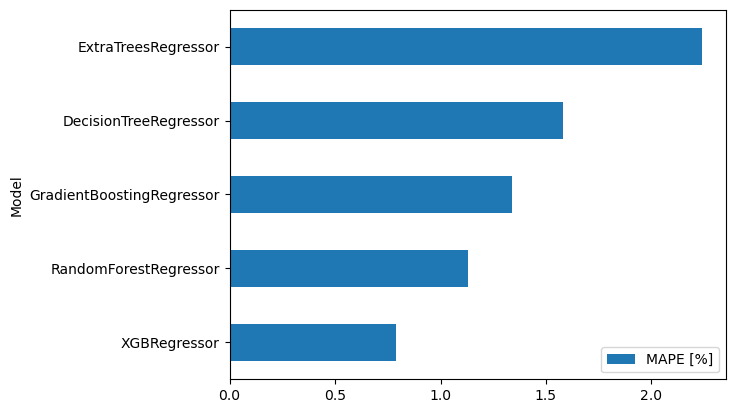

In [24]:
df2 = pd.DataFrame({
    'Model':['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor'], 
    'MAPE [%]':[1.58, 1.13, 2.24, 1.34, 0.79]})
df2 = df2.sort_values(by=['MAPE [%]'])
ax = df2.plot.barh(x='Model', y='MAPE [%]', rot=0)
y=df2['MAPE [%]']